In [1]:
version = 'v20250521'

import pandas as pd
from sklearn.model_selection import GroupKFold,cross_val_predict
from skmap.misc import find_files, GoogleSheet, ttprint
from sklearn.ensemble import RandomForestRegressor, IsolationForest
import joblib
import numpy as np

random_state = 42

In [2]:
pnt = pd.read_parquet(f'./metric/point_predicted_{version}.pq')
name_map = {'ndvi_glad.landast.ard2.seasconv.m.yearly_p50_30m_s_YYYY0101_YYYY1231_eu_epsg.3035_v20231127':'ndvi',
            'ndwi.gao_glad.landsat.ard2.seasconv.m.yearly_p50_30m_s_YYYY0101_YYYY1231_eu_epsg.3035_v20231218':'ndwi'}

pnt = pnt.rename(columns = name_map)
            
for col in ['ndvi','ndwi']:
    pnt[col] = (pnt[col]-125)/125
    
# calculate snr, error and abs_error for each pnt
pnt['snr'] = pnt['pred']/pnt['pred_std']
pnt['error'] = pnt['pred'] - pnt['soc']
pnt['abs_error'] = pnt['error'].abs()
pnt['signal'] = pnt['pred'].abs()
pnt['rae'] = pnt['abs_error']/pnt['soc']

In [3]:
pair = pd.read_parquet(f'./metric/pair_predicted_{version}.pq')
pair = pair.drop(columns=['time_pair_y','lc_survey_pair_x','pred_pair'])
pair = pair.rename(columns={'pred_change_pnt':'pred_pnt','pred':'pred_pair','pred_std':'noise_pair',
                            'time_pair_x':'time_pair','lc_survey_pair_y':'lc_survey_pair'})
pair['signal_pnt'] = pair['pred_pnt'].abs()
pair['signal_pair'] = pair['pred_pair'].abs()
pair['snr_pnt'] = pair['signal_pnt']/pair['noise_pnt']
pair['snr_pair'] = pair['signal_pair']/pair['noise_pair']
pair['lc_str'] = pair['lc_survey_pair'].str[0] + '-' + pair['lc_survey_pair'].str[1]
pair['error'] = pair['pred_pnt'] - pair['soc_change']
pair['abs_error'] = pair['error'].abs()
pair['rae'] = pair['abs_error']/pair['soc_change'].abs()
pair.loc[pair['soc_change'].abs()<1, 'rae'] =  pair.loc[pair['soc_change'].abs()<1, 'abs_error'] # "normalize" rae, with detectability floor == 1

In [4]:
srs = pd.read_parquet(f'./metric/srs_predicted_{version}.pq')
srs = srs[srs.columns[0:21].tolist()+srs.columns[-24::].tolist()]

srs = srs.rename(columns={'slope_pred':'pred_pnt', 'slope_std':'noise_pnt','pred':'pred_srs','pred_std':'noise_srs'})
srs['signal_pnt'] = srs['pred_pnt'].abs()
srs['signal_srs'] = srs['pred_srs'].abs()
srs['snr_pnt'] = srs['signal_pnt']/srs['noise_pnt']
srs['snr_srs'] = srs['signal_srs']/srs['noise_srs']
srs['error'] = srs['pred_pnt'] - srs['slope_obsv']
srs['rae'] = srs['error'].abs()/srs['slope_obsv'].abs()
srs['abs_error'] = srs['error'].abs()
srs.loc[srs['slope_obsv'].abs()<0.5, 'rae'] =  srs.loc[srs['slope_obsv'].abs()<0.5, 'abs_error']/0.5

In [73]:
srs[['rae','abs_error','snr_srs','snr_pnt']].corr(method='kendall')

,rae,abs_error,snr_srs,snr_pnt
rae,1.000000,0.667607,0.154406,0.052448
abs_error,0.667607,1.000000,0.231063,0.008347
snr_srs,0.154406,0.231063,1.000000,-0.082146
snr_pnt,0.052448,0.008347,-0.082146,1.000000


In [79]:
srs[['rae','abs_error','snr_srs','snr_pnt']].corr(method='pearson')

,rae,abs_error,snr_srs,snr_pnt
rae,1.000000,0.166278,0.126257,0.180818
abs_error,0.166278,1.000000,0.210908,0.006699
snr_srs,0.126257,0.210908,1.000000,-0.098626
snr_pnt,0.180818,0.006699,-0.098626,1.000000


In [74]:
pair[['rae','abs_error','snr_pair','snr_pnt']].corr(method='kendall')

,rae,abs_error,snr_pair,snr_pnt
rae,1.000000,0.266002,0.029619,0.145706
abs_error,0.266002,1.000000,0.232078,0.045633
snr_pair,0.029619,0.232078,1.000000,-0.026540
snr_pnt,0.145706,0.045633,-0.026540,1.000000


In [76]:
pair[['rae','abs_error','snr_pair','snr_pnt']].corr(method='pearson')

,rae,abs_error,snr_pair,snr_pnt
rae,1.000000,0.023986,0.074735,0.259299
abs_error,0.023986,1.000000,0.181889,0.000736
snr_pair,0.074735,0.181889,1.000000,-0.005883
snr_pnt,0.259299,0.000736,-0.005883,1.000000


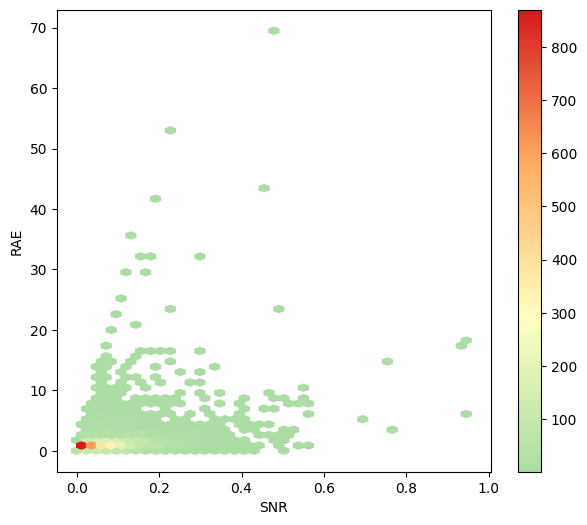

In [70]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap


cet_l19_cmap = LinearSegmentedColormap.from_list(
    "CET-L19", ["#abdda4", "#ffffbf", "#fdae61", "#d7191c"]
)

fig, ax = plt.subplots(figsize=(7, 6))           # safer helper
hb = ax.hexbin(
        pair['snr_pnt'], pair['rae'],#.abs(), 
        gridsize=(40, 40),
        cmap=cet_l19_cmap,   # or any cmap you like
        mincnt=1,
        # vmax=vmax,               # drop this if you want auto-scaling
        # bins='log'
)
ax.set_ylabel('RAE')
ax.set_xlabel('SNR')

fig.colorbar(hb, ax=ax)
plt.show()

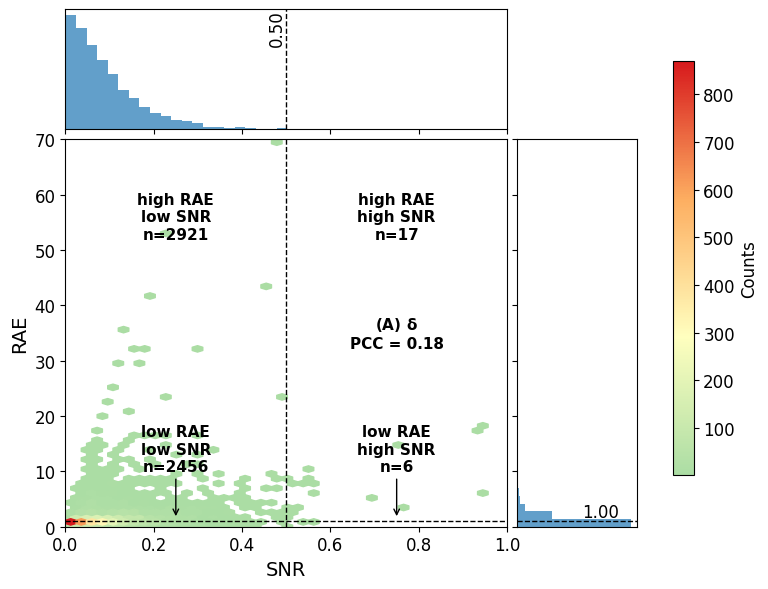

In [84]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np

# --------------------------------------------------------------
# 0.  YOUR DATA  – pair must supply two 1-D arrays/Series
# --------------------------------------------------------------
# pair = {"snr_pnt": ..., "rae": ...}

# --------------------------------------------------------------
# 1.  CONSTANTS & QUANTILES
# --------------------------------------------------------------
cet_l19_cmap = LinearSegmentedColormap.from_list(
    "CET-L19", ["#abdda4", "#ffffbf", "#fdae61", "#d7191c"]
)

# q_snr = np.quantile(pair["snr_pnt"], 0.75)    # vertical threshold
# q_rae = np.quantile(pair["rae"],     0.75)    # horizontal threshold
q_snr = 0.5
q_rae = 1


# --------------------------------------------------------------
# 2.  FIGURE LAYOUT  (main + top + right axes)
# --------------------------------------------------------------
fig, ax_main = plt.subplots(figsize=(8, 6))
divider   = make_axes_locatable(ax_main)
ax_top    = divider.append_axes("top",  1.2, pad=0.1, sharex=ax_main)
ax_right  = divider.append_axes("right", 1.2, pad=0.1, sharey=ax_main)

# Turn off tick labels where axes are shared
plt.setp(ax_top.get_xticklabels(), visible=False)
plt.setp(ax_right.get_yticklabels(), visible=False)

# --------------------------------------------------------------
# 3.  MAIN HEXBIN
# --------------------------------------------------------------
hb = ax_main.hexbin(
    pair["snr_pnt"], pair["rae"],
    gridsize=(40, 40),
    cmap=cet_l19_cmap,
    mincnt=1,
)

# (a) dashed 75 % cut-off lines
ax_main.axvline(q_snr, color="k", ls="--", lw=1)
ax_main.axhline(q_rae, color="k", ls="--", lw=1)

# (b) axis labels + **fixed limits**
ax_main.set_xlabel("SNR",fontsize=14)
ax_main.set_ylabel("RAE",fontsize=14)
ax_main.set_xlim(0, 1)          # <-- x-range
ax_main.set_ylim(0, 70)         # <-- y-range
ax_main.tick_params(axis='both', which='major', labelsize=12)

# (c) colour-bar, **shrunk to 80 %**
cbar = fig.colorbar(hb, ax=ax_main, label="Counts", shrink=0.8)
cbar.ax.tick_params(labelsize=12)
cbar.set_label("Counts", fontsize=12)
# --------------------------------------------------------------
# 4.  MARGINAL HISTOGRAMS  –  density plots, no y-axes
# --------------------------------------------------------------

# ── Top histogram – SNR ────────────────────────────────────────
ax_top.hist(
    pair["snr_pnt"],
    bins=40,
    histtype="stepfilled",
    alpha=0.7,
    density=True,                 # ← plot density, not counts
)
ax_top.axvline(q_snr, color="k", ls="--", lw=1)
ax_top.text(
    q_snr, ax_top.get_ylim()[1]*0.85,
    f"{q_snr:.2f}", rotation=90,
    ha="right", va="center", fontsize=12, color="k",
)
ax_top.set_ylabel("")             # no y-axis label
ax_top.yaxis.set_visible(False)   # ← hide y-axis (ticks + spine)

# ── Right histogram – RAE ──────────────────────────────────────
ax_right.hist(
    pair["rae"],
    bins=50,
    orientation="horizontal",
    histtype="stepfilled",
    alpha=0.7,
    density=True,                 # ← plot density, not counts
)
ax_right.axhline(q_rae, color="k", ls="--", lw=1)
ax_right.text(
    ax_right.get_xlim()[1]*0.85, q_rae,
    f"{q_rae:.2f}",
    ha="right", va="bottom", fontsize=12, color="k",
)
ax_right.set_ylabel("")
ax_right.xaxis.set_visible(False) # ← hide y-axis here too


# --------------------------------------------------------------
# 5.  OPTIONAL: annotate quadrant counts (reuse code from earlier)
# --------------------------------------------------------------
hi_snr = pair["snr_pnt"] >= q_snr
hi_rae = pair["rae"]     >= q_rae
lo_snr = ~hi_snr
lo_rae = ~hi_rae

counts = {
    "high RAE, high SNR": (hi_rae & hi_snr).sum(),
    "high RAE, low  SNR": (hi_rae & lo_snr).sum(),
    "low  RAE, high SNR": (lo_rae & hi_snr).sum(),
    "low  RAE, low  SNR": (lo_rae & lo_snr).sum(),
}

ax_main.text(0.75, 0.80,
             f"high RAE\nhigh SNR\nn={counts['high RAE, high SNR']}",
             transform=ax_main.transAxes, ha="center", va="center",
             weight="bold", fontsize=11)
ax_main.text(0.25, 0.80,
             f"high RAE\nlow SNR\nn={counts['high RAE, low  SNR']}",
             transform=ax_main.transAxes, ha="center", va="center",
             weight="bold", fontsize=11)
ax_main.text(0.75, 0.20,
             f"low RAE\nhigh SNR\nn={counts['low  RAE, high SNR']}",
             transform=ax_main.transAxes, ha="center", va="center",
             weight="bold", fontsize=11)
ax_main.annotate(
    "", xy=(0.75, 0.02), xytext=(0.75, 0.13),
    textcoords="axes fraction", xycoords="axes fraction",
    arrowprops=dict(arrowstyle="->", color="black", lw=1)
)
ax_main.text(0.25, 0.20,
             f"low RAE\nlow SNR\nn={counts['low  RAE, low  SNR']}",
             transform=ax_main.transAxes, ha="center", va="center",
             weight="bold", fontsize=11)
ax_main.annotate(
    "", xy=(0.25, 0.02), xytext=(0.25, 0.13),
    textcoords="axes fraction", xycoords="axes fraction",
    arrowprops=dict(arrowstyle="->", color="black", lw=1)
)
ax_main.text(
    0.75, 0.50,
    r"(A) $\mathbf{\delta}$" + "\n" + "PCC = 0.18",   # or: r"(B) $\mathbf{\beta}$"
    transform=ax_main.transAxes,
    ha="center", va="center",
    fontsize=11,
    fontweight="bold",             # bold for the “(B)” part
)
plt.tight_layout()
plt.savefig('./figure/plot_pair_snr.rae.svg', bbox_inches='tight')
plt.show()


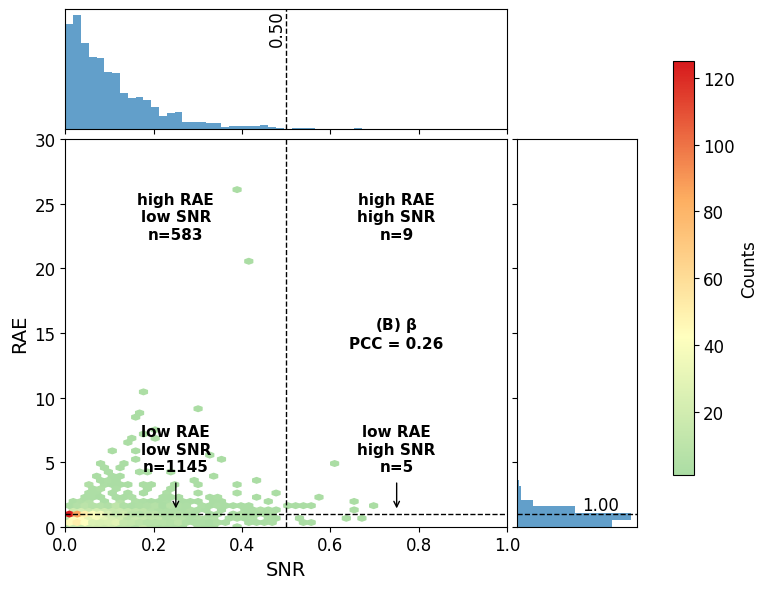

In [83]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np

# --------------------------------------------------------------
# 0.  YOUR DATA  – pair must supply two 1-D arrays/Series
# --------------------------------------------------------------
# pair = {"snr_pnt": ..., "rae": ...}

# --------------------------------------------------------------
# 1.  CONSTANTS & QUANTILES
# --------------------------------------------------------------
cet_l19_cmap = LinearSegmentedColormap.from_list(
    "CET-L19", ["#abdda4", "#ffffbf", "#fdae61", "#d7191c"]
)

# q_snr = np.quantile(pair["snr_pnt"], 0.75)    # vertical threshold
# q_rae = np.quantile(pair["rae"],     0.75)    # horizontal threshold
q_snr = 0.5
q_rae = 1


# --------------------------------------------------------------
# 2.  FIGURE LAYOUT  (main + top + right axes)
# --------------------------------------------------------------
fig, ax_main = plt.subplots(figsize=(8, 6))
divider   = make_axes_locatable(ax_main)
ax_top    = divider.append_axes("top",  1.2, pad=0.1, sharex=ax_main)
ax_right  = divider.append_axes("right", 1.2, pad=0.1, sharey=ax_main)

# Turn off tick labels where axes are shared
plt.setp(ax_top.get_xticklabels(), visible=False)
plt.setp(ax_right.get_yticklabels(), visible=False)

# --------------------------------------------------------------
# 3.  MAIN HEXBIN
# --------------------------------------------------------------
hb = ax_main.hexbin(
    srs["snr_pnt"], srs["rae"],
    gridsize=(40, 40),
    cmap=cet_l19_cmap,
    mincnt=1,
)

# (a) dashed 75 % cut-off lines
ax_main.axvline(q_snr, color="k", ls="--", lw=1)
ax_main.axhline(q_rae, color="k", ls="--", lw=1)

# (b) axis labels + **fixed limits**
ax_main.set_xlabel("SNR",fontsize=14)
ax_main.set_ylabel("RAE",fontsize=14)
ax_main.set_xlim(0, 1)          # <-- x-range
ax_main.set_ylim(0, 30)         # <-- y-range
ax_main.tick_params(axis='both', which='major', labelsize=12)

# (c) colour-bar, **shrunk to 80 %**
cbar = fig.colorbar(hb, ax=ax_main, label="Counts", shrink=0.8)
cbar.ax.tick_params(labelsize=12)
cbar.set_label("Counts", fontsize=12)
# --------------------------------------------------------------
# 4.  MARGINAL HISTOGRAMS  –  density plots, no y-axes
# --------------------------------------------------------------

# ── Top histogram – SNR ────────────────────────────────────────
ax_top.hist(
    srs["snr_pnt"],
    bins=40,
    histtype="stepfilled",
    alpha=0.7,
    density=True,                 # ← plot density, not counts
)
ax_top.axvline(q_snr, color="k", ls="--", lw=1)
ax_top.text(
    q_snr, ax_top.get_ylim()[1]*0.85,
    f"{q_snr:.2f}", rotation=90,
    ha="right", va="center", fontsize=12, color="k",
)
ax_top.set_ylabel("")             # no y-axis label
ax_top.yaxis.set_visible(False)   # ← hide y-axis (ticks + spine)

# ── Right histogram – RAE ──────────────────────────────────────
ax_right.hist(
    srs["rae"],
    bins=50,
    orientation="horizontal",
    histtype="stepfilled",
    alpha=0.7,
    density=True,                 # ← plot density, not counts
)
ax_right.axhline(q_rae, color="k", ls="--", lw=1)
ax_right.text(
    ax_right.get_xlim()[1]*0.85, q_rae,
    f"{q_rae:.2f}",
    ha="right", va="bottom", fontsize=12, color="k",
)
ax_right.set_ylabel("")
ax_right.xaxis.set_visible(False) # ← hide y-axis here too


# --------------------------------------------------------------
# 5.  OPTIONAL: annotate quadrant counts (reuse code from earlier)
# --------------------------------------------------------------
hi_snr = srs["snr_pnt"] >= q_snr
hi_rae = srs["rae"]     >= q_rae
lo_snr = ~hi_snr
lo_rae = ~hi_rae

counts = {
    "high RAE, high SNR": (hi_rae & hi_snr).sum(),
    "high RAE, low  SNR": (hi_rae & lo_snr).sum(),
    "low  RAE, high SNR": (lo_rae & hi_snr).sum(),
    "low  RAE, low  SNR": (lo_rae & lo_snr).sum(),
}

ax_main.text(0.75, 0.80,
             f"high RAE\nhigh SNR\nn={counts['high RAE, high SNR']}",
             transform=ax_main.transAxes, ha="center", va="center",
             weight="bold", fontsize=11)
ax_main.text(0.25, 0.80,
             f"high RAE\nlow SNR\nn={counts['high RAE, low  SNR']}",
             transform=ax_main.transAxes, ha="center", va="center",
             weight="bold", fontsize=11)
ax_main.text(0.75, 0.20,
             f"low RAE\nhigh SNR\nn={counts['low  RAE, high SNR']}",
             transform=ax_main.transAxes, ha="center", va="center",
             weight="bold", fontsize=11)
ax_main.annotate(
    "", xy=(0.75, 0.04), xytext=(0.75, 0.12),
    textcoords="axes fraction", xycoords="axes fraction",
    arrowprops=dict(arrowstyle="->", color="black", lw=1)
)
ax_main.text(0.25, 0.20,
             f"low RAE\nlow SNR\nn={counts['low  RAE, low  SNR']}",
             transform=ax_main.transAxes, ha="center", va="center", 
             weight='bold', fontsize=11)
ax_main.annotate(
    "", xy=(0.25, 0.04), xytext=(0.25, 0.12),
    textcoords="axes fraction", xycoords="axes fraction",
    arrowprops=dict(arrowstyle="->", color="black", lw=1)
)
ax_main.text(
    0.75, 0.50,
    r"(B) $\mathbf{\beta}$" + "\n" + "PCC = 0.26",   # or: r"(B) $\mathbf{\beta}$"
    transform=ax_main.transAxes,
    ha="center", va="center",
    fontsize=11,
    fontweight="bold",             # bold for the “(B)” part
)
plt.tight_layout()
plt.savefig('./figure/plot_srs_snr.rae.svg', bbox_inches='tight')
plt.show()

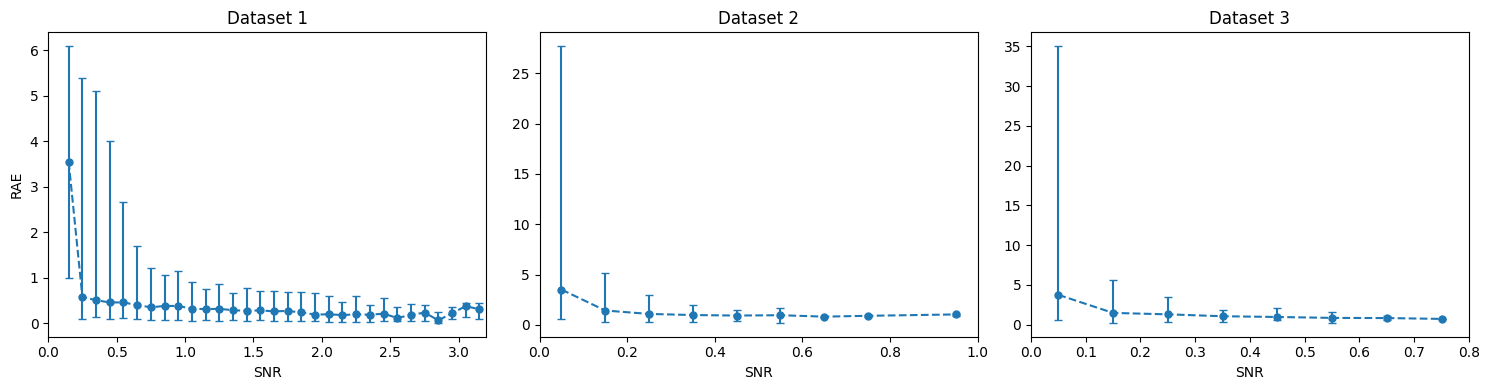

In [107]:
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt

# # ----------------------------------------
# # 1.  Data lists
# # ----------------------------------------
# max_bins = [3.2, 1.0, 0.8]
# widths   = [0.1, 0.1, 0.1]
# snrs     = [pnt['snr'],          pair['snr_pnt'],          srs['snr_pnt']]
# errs     = [pnt['error'].abs()/pnt['signal'],
#             pair['error'].abs()/pair['signal_pnt'],
#             srs['error'].abs()/srs['signal_pnt']]

# # ----------------------------------------
# # 2.  Figure scaffold
# # ----------------------------------------
# fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharey=False)

# # ----------------------------------------
# # 3.  Loop over the three data sets
# # ----------------------------------------
# for idx, ax in enumerate(axes):

#     # -- bin parameters for this panel --
#     max_bin   = max_bins[idx]
#     BIN_WIDTH = widths[idx]
#     snr       = snrs[idx]
#     err       = errs[idx]

#     # -- digitise SNR into 0.1-wide bins --
#     edges       = np.arange(0, max_bin + BIN_WIDTH, BIN_WIDTH)
#     bin_centres = edges[:-1] + BIN_WIDTH / 2
#     bin_idx     = np.digitize(snr, edges) - 1

#     # -- build a tidy frame & drop out-of-range rows --
#     df = pd.DataFrame({'bin': bin_idx, 'rae': err})
#     df = df[(df['bin'] >= 0) & (df['bin'] < len(bin_centres))]

#     # -- per-bin stats: 10th, mean, 90th --
#     summary = (
#         df.groupby('bin')['rae']
#           .agg(p10  = lambda x: np.percentile(x, 10),
#                p90  = lambda x: np.percentile(x, 90)
#     )
#     summary['snr_bin_center'] = bin_centres[summary['bin']]

#     # -- asymmetric error bar (10 %–90 %) --
#     yerr = np.vstack([
#         summary['mean'] - summary['p10'],   # below mean
#         summary['p90']  - summary['mean']   # above mean
#     ])

#     ax.errorbar(summary['snr_bin_center'], summary['mean'],
#                 yerr=yerr,
#                 fmt='o--', linewidth=1.5, markersize=5, capsize=3)

#     # -- cosmetics --
#     ax.set_xlabel('SNR')
#     ax.set_title(f'Dataset {idx + 1}')
#     ax.set_xlim(0, max_bin)

# axes[0].set_ylabel('RAE')
# fig.tight_layout()
# plt.show()


## srs

In [2]:

# params
prop = 'slope'
tgt = 'ts_slope'
space = 'normal'

# covs
covs = pd.read_csv(f'./metric/feature_selected_{prop}_{version}.txt', header=None)[0].tolist() 
# train data
train = pd.read_parquet(f'./material/srs_train_{version}.pq')
train = train.dropna(subset=covs+[tgt],how='any').reset_index(drop=True)
# test
srs = pd.read_parquet(f'./metric/srs_predicted.srs_{version}.pq')
# train isolation forest
isof = IsolationForest(random_state=random_state)
isof.fit(train[covs])

iso_class = isof.predict(srs[covs])
srs['Anomaly'] = isof.decision_function(srs[covs]) # inlier -> 0, outlier -> -1
srs['Anomaly'] = srs['Anomaly']*(-1) # inlier -> 0, outlier -> 1, the higher the score is, the more abnormal it is

In [3]:
srs['signal'] = srs['ts_slope'].abs()
srs = srs.rename(columns={'ndvi_glad.landast.ard2.seasconv.m.yearly_p50_30m_s_20000101_20001231_eu_epsg.3035_v20231127_full_mean':'NDVI','pred_std':'noise_srs'})
srs['SNR'] = srs['signal']/srs['noise_srs']
srs['SOC'] = srs['soc_series'].apply(lambda x: np.mean(x))

In [4]:
srs['error'] = srs['pred'] - srs[tgt]
srs[r'RAE'] = srs['error'].abs()/srs['signal'] #$Error_{\mathrm{abs}}$

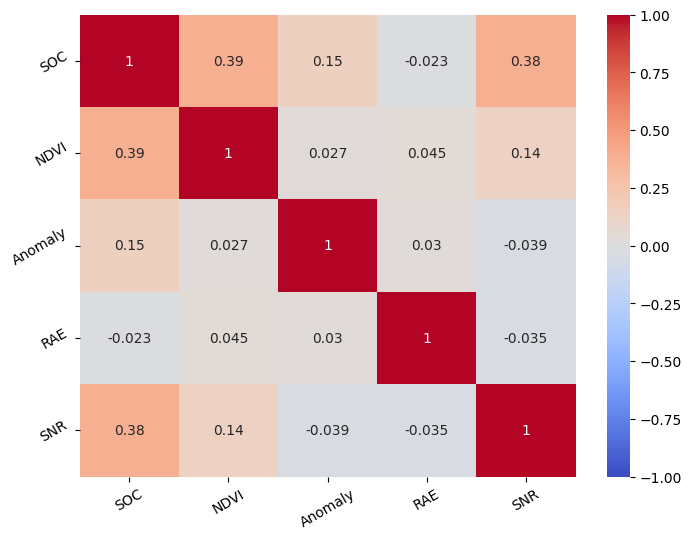

In [5]:
coe_srs = srs[['SOC','NDVI','Anomaly',r'RAE','SNR']].corr()

import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(8,6))
ax = sns.heatmap(coe_srs, cmap="coolwarm", annot=True, vmin=-1, vmax=1, center=0)
ax.tick_params(axis='both', rotation=30)
# plt.savefig(f'./figure/plot_corr_pair.metrics.pdf', bbox_inches='tight')
plt.show()

## pair

In [6]:
# params
prop = 'change'
tgt = 'soc_change'
space = 'normal'

# covs
covs = pd.read_csv(f'./metric/feature_selected_{prop}_{version}.txt', header=None)[0].tolist() 
# train data
train = pd.read_parquet(f'./material/pair_train_{version}.pq')
train = train.dropna(subset=covs+[tgt],how='any').reset_index(drop=True)
# test
pair = pd.read_parquet(f'./metric/pair_predicted.pair_{version}.pq')
# train isolation forest
isof = IsolationForest(random_state=random_state)
isof.fit(train[covs])

iso_class = isof.predict(pair[covs])
pair['Anomaly'] = isof.decision_function(pair[covs]) 
pair['Anomaly'] = pair['Anomaly']*(-1) 

In [7]:
pair = pair.rename(columns={'ndvi_glad.landast.ard2.seasconv.m.yearly_p50_30m_s_20000101_20001231_eu_epsg.3035_v20231127_full_mean':'NDVI','pred_std':'noise_pair','soc_mean':'SOC'})
pair['signal'] = pair['soc_change'].abs()
pair['SNR'] = pair['signal']/pair['noise_pair']

pair['error'] = pair['pred'] - pair[tgt]
pair[r'RAE'] = pair['error'].abs()/pair['signal']

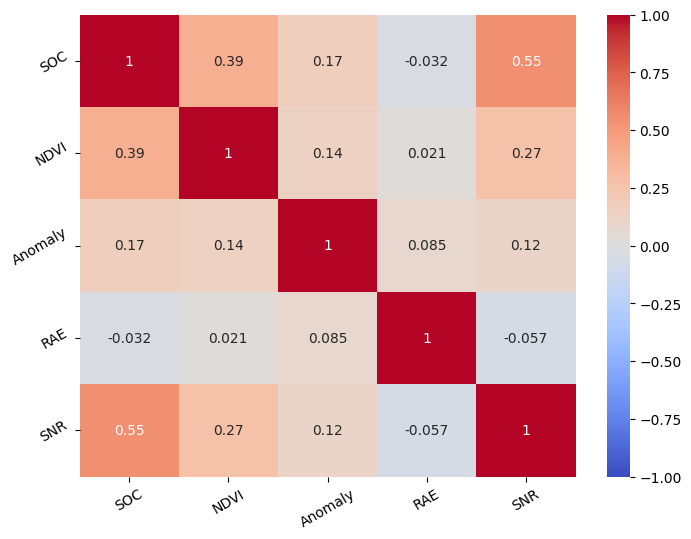

In [8]:
coe_pair = pair[['SOC','NDVI','Anomaly',r'RAE','SNR']].corr()

import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(8,6))
ax = sns.heatmap(coe_pair, cmap="coolwarm", annot=True, vmin=-1, vmax=1, center=0)
ax.tick_params(axis='both', rotation=30)
# plt.savefig(f'./figure/plot_corr_pair.metrics.pdf', bbox_inches='tight')
plt.show()

## point

In [9]:
prop = 'soc'
tgt = 'soc_log1p'

covs = pd.read_csv(f'./metric/feature_selected_soc_{version}.txt', header=None)[0].tolist() 
model = joblib.load(f'./model/model_rf.soc_ccc_{version}.joblib')
model.n_jobs = 90

train = pd.read_parquet(f'./material/pnt_train_{version}.pq')
train = train.dropna(subset=covs+[tgt],how='any').reset_index(drop=True)
test = pd.read_parquet(f'./metric/point_predicted_{version}.pq')
test = test.dropna(subset=covs+[tgt],how='any').reset_index(drop=True)

# train isolation forest
isof = IsolationForest(random_state=random_state)
isof.fit(train[covs])

iso_class = isof.predict(test[covs])
test['Anomaly'] = isof.decision_function(test[covs]) 
test['Anomaly'] = test['Anomaly']*(-1) 

In [10]:
test = test.rename(columns={'ndvi_glad.landast.ard2.seasconv.m.yearly_p50_30m_s_YYYY0101_YYYY1231_eu_epsg.3035_v20231127':'NDVI','soc':'SOC'})
test['SNR'] = test['SOC']/test['pred_std']
test['error'] = test['pred'] - test['SOC']
test[r'RAE'] = test['error'].abs()/test['SOC']

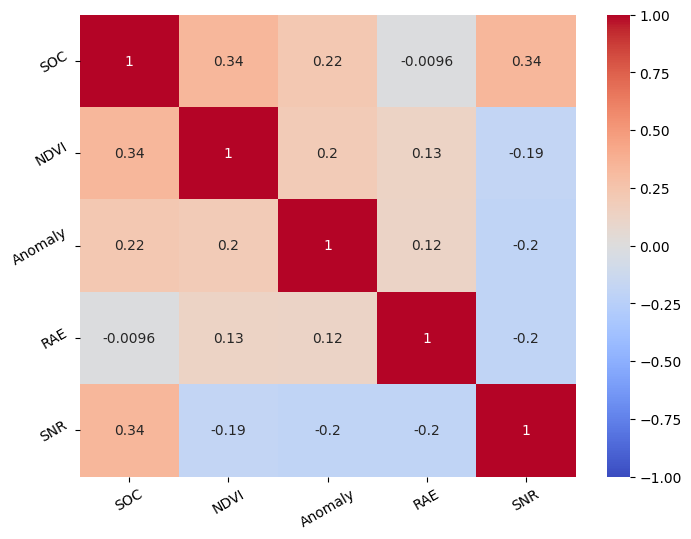

In [11]:
coe_pnt = test[['SOC','NDVI','Anomaly',r'RAE','SNR']].corr()

import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(8,6))
ax = sns.heatmap(coe_pnt, cmap="coolwarm", annot=True, vmin=-1, vmax=1, center=0)
ax.tick_params(axis='both', rotation=30)
plt.show()

## plot together

/tmp/ipykernel_130889/36690720.py:42: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.15, 1, 1])


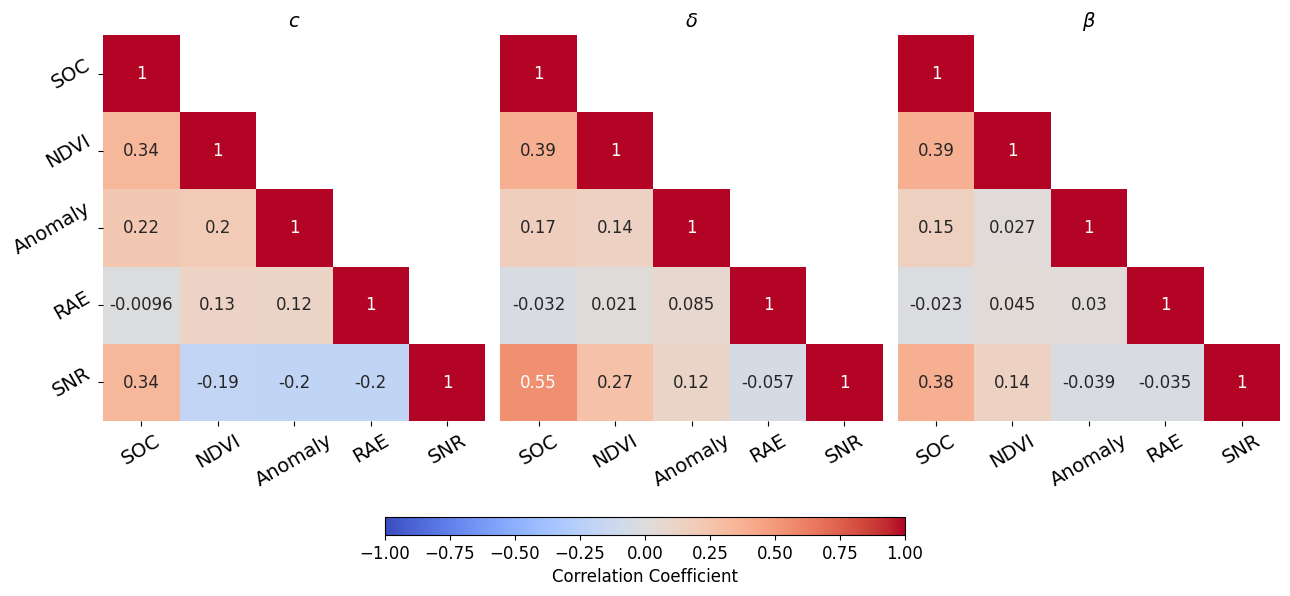

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

titles = [r'$c$', r'$\delta$', r'$\beta$']
matrices = [coe_pnt, coe_pair, coe_srs]
mask = np.triu(np.ones_like(coe_pnt, dtype=bool),k=1)

fig, axes = plt.subplots(1, 3, figsize=(13, 6))

vmin, vmax = -1, 1

for i, (ax, matrix, title) in enumerate(zip(axes, matrices, titles)):
    sns.heatmap(
        matrix,
        ax=ax,
        mask=mask,
        cmap="coolwarm",
        annot=True,
        vmin=vmin,
        vmax=vmax,
        center=0,
        cbar=False,
        annot_kws={"size": 12},
        yticklabels=(i == 0),  # Show y-tick labels only on the first plot
        # linewidths=0.5,
        # linecolor='black'
    )
    ax.set_title(title.capitalize(), fontsize=14)
    ax.tick_params(axis='x', rotation=30,labelsize=14)
    ax.tick_params(axis='y', rotation=30,labelsize=14)

cbar_ax = fig.add_axes([0.3, 0.1, 0.4, 0.03])  # [left, bottom, width, height]
norm = plt.Normalize(vmin=vmin, vmax=vmax)
sm = plt.cm.ScalarMappable(cmap="coolwarm", norm=norm)
sm.set_array([])

cbar = fig.colorbar(sm, cax=cbar_ax, orientation="horizontal")
cbar.ax.tick_params(labelsize=12)
cbar.set_label("Correlation Coefficient", fontsize=12)

plt.tight_layout(rect=[0, 0.15, 1, 1])
plt.savefig(f'./figure/plot_corr_metrics.pdf', bbox_inches='tight')
plt.show()
